In [4]:
import numpy as np
import pandas as pd
import os, datetime
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')


Tensorflow version: 2.6.0


## Hyperparameters


In [5]:
batch_size = 32
seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

## 대한항공 주가와 환율, 유가 데이터 로드 

In [6]:
ka_path = '/content/koreanAir-stock-data-1980-2021.csv'

df = pd.read_csv(ka_path, delimiter=',')

# Replace 0 to avoid dividing by 0 later on
df['vol'].replace(to_replace=0, method='ffill', inplace=True) # 일시적으로만 0을 대체
df.sort_values('date', inplace=True)
df.drop(['section', 'code', 'name', 'value', 'n_stock', 'agg_price', 'foreign_vol', 'agency_netbuy', 'agency_buy', 'foreign_rate'], axis = 1, inplace= True) 
df

,date,open,high,low,close,vol
0,19801004,808,815,806,806,5050
1,19801006,790,805,764,782,7904
2,19801007,780,780,745,745,7449
3,19801008,738,740,727,733,12071
4,19801010,726,727,712,719,8257
...,...,...,...,...,...,...
10931,20210818,28700,29400,28500,29200,1473161
10932,20210819,28900,29100,28400,28400,1758907
10933,20210820,28400,28650,27300,27600,2550946
10934,20210823,27600,29000,27550,28700,1899431


In [7]:
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume'] 
df

,Date,Open,High,Low,Close,Volume
0,19801004,808,815,806,806,5050
1,19801006,790,805,764,782,7904
2,19801007,780,780,745,745,7449
3,19801008,738,740,727,733,12071
4,19801010,726,727,712,719,8257
...,...,...,...,...,...,...
10931,20210818,28700,29400,28500,29200,1473161
10932,20210819,28900,29100,28400,28400,1758907
10933,20210820,28400,28650,27300,27600,2550946
10934,20210823,27600,29000,27550,28700,1899431


In [8]:
oil_path_1 = '/content/oil1.csv' 
oil_path_2 = '/content/oil2.csv' 
df1 = pd.read_csv(oil_path_1, delimiter=',') 
df2 = pd.read_csv(oil_path_2, delimiter=',')  
df_oil = pd.concat([df1, df2], ignore_index = True) 
def date_change(ss):
  ans = ''
  for s in ss:
    if s.isdigit():
      ans+=s 
  return int(ans) 
def close_change(ss):
  ans = ''
  for s in ss:
    if s != ',':
      ans+=s 
  return ans 

df_oil['날짜'] = df_oil['날짜'].apply(date_change) 
df_oil.drop_duplicates(['날짜'], inplace= True)
df_oil.drop(['오픈', '고가', '저가', '변동 %', '거래량'], axis =1, inplace= True) 
df_oil.columns = ['Date', 'Close']  
df_oil['Close'] = df_oil['Close'].apply(pd.to_numeric)
df_oil.sort_values(by = ['Date'], inplace= True, ignore_index= True)  
df_oil

,Date,Close
0,19830331,29.27
1,19830404,29.44
2,19830405,29.71
3,19830406,29.90
4,19830407,30.17
...,...,...
9730,20210819,63.69
9731,20210820,62.32
9732,20210823,65.64
9733,20210824,67.54


In [9]:
dollar_path_1 = '/content/dollar_1.csv' 
dollar_path_2 = '/content/dollar_2.csv' 
dollar_path_3 = '/content/dollar_3.csv'  
df1 = pd.read_csv(dollar_path_1, delimiter=',') 
df2 = pd.read_csv(dollar_path_2, delimiter=',')  
df3 = pd.read_csv(dollar_path_3, delimiter=',')   
df_12 = pd.concat([df1, df2], ignore_index= True) 
df_ex = pd.concat([df_12, df3], ignore_index= True) 
df_ex['날짜'] = df_ex['날짜'].apply(date_change)
df_ex.drop_duplicates(['날짜'], inplace= True) 
df_ex.drop(['오픈', '고가', '저가', '변동 %'], axis =1, inplace= True)  
df_ex.columns = ['Date', 'Close']  
df_ex['Close'] = df_ex['Close'].apply(close_change) 
df_ex['Close'] = df_ex['Close'].apply(pd.to_numeric)
df_ex.sort_values(by = ['Date'], inplace= True, ignore_index= True)
df_ex['Close'] = df_ex['Close'].apply(pd.to_numeric)
df_ex

,Date,Close
0,19810414,676.70
1,19810415,676.70
2,19810416,676.70
3,19810417,676.75
4,19810420,676.70
...,...,...
10409,20210819,1176.28
10410,20210820,1175.15
10411,20210822,1175.24
10412,20210823,1169.36


## Date 통일시키기 


In [10]:
df= df[df['Date']>=19830331]
df_ex = df_ex[df_ex['Date'] >= 19830331] 
df_merge = pd.merge(df, df_oil, how = 'outer', on = 'Date') 
df_train = pd.merge(df_merge, df_ex, how= 'outer', on = 'Date') 
df_train.dropna(axis=0, inplace= True)

In [11]:
df_train 

,Date,Open,High,Low,Close_x,Volume,Close_y,Close
0,19830331,1025.0,1027.0,1022.0,1027.0,18039.0,29.27,763.55
3,19830404,1038.0,1038.0,1029.0,1034.0,8215.0,29.44,763.55
4,19830406,1034.0,1034.0,1025.0,1025.0,4756.0,29.90,763.55
5,19830407,1020.0,1025.0,1018.0,1025.0,6616.0,30.17,763.55
6,19830408,1025.0,1036.0,1018.0,1034.0,50692.0,30.38,763.55
...,...,...,...,...,...,...,...,...
10204,20210818,28700.0,29400.0,28500.0,29200.0,1473161.0,65.46,1170.03
10205,20210819,28900.0,29100.0,28400.0,28400.0,1758907.0,63.69,1176.28
10206,20210820,28400.0,28650.0,27300.0,27600.0,2550946.0,62.32,1175.15
10207,20210823,27600.0,29000.0,27550.0,28700.0,1899431.0,65.64,1169.36


In [12]:
df

,Date,Open,High,Low,Close,Volume
727,19830331,1025,1027,1022,1027,18039
728,19830401,1027,1043,1025,1040,35784
729,19830402,1040,1040,1034,1040,6103
730,19830404,1038,1038,1029,1034,8215
731,19830406,1034,1034,1025,1025,4756
...,...,...,...,...,...,...
10931,20210818,28700,29400,28500,29200,1473161
10932,20210819,28900,29100,28400,28400,1758907
10933,20210820,28400,28650,27300,27600,2550946
10934,20210823,27600,29000,27550,28700,1899431


## Plot daily 대한항공 closing prcie and volume


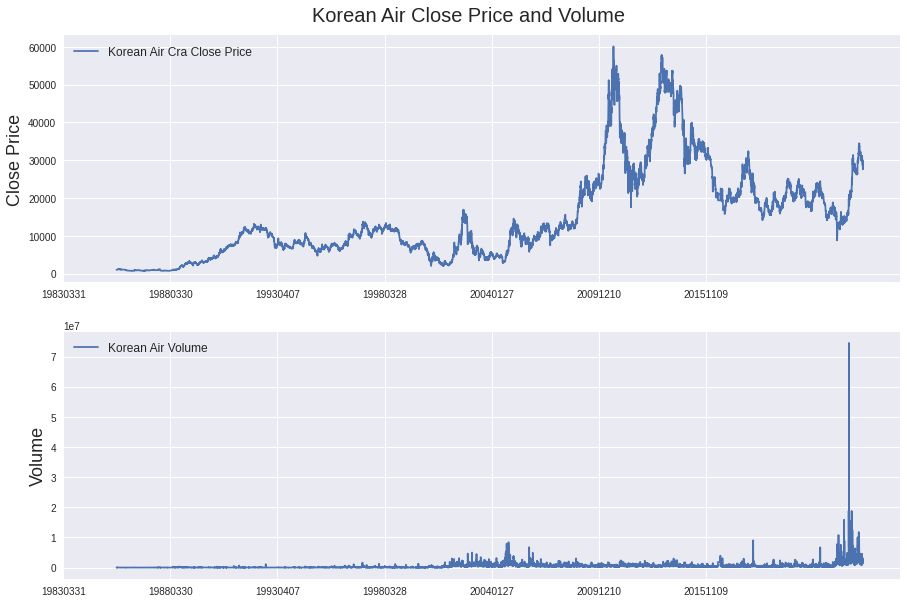

In [13]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("Korean Air Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label= 'Korean Air Cra Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='Korean Air Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

## Plot WTI index and exchange ratio

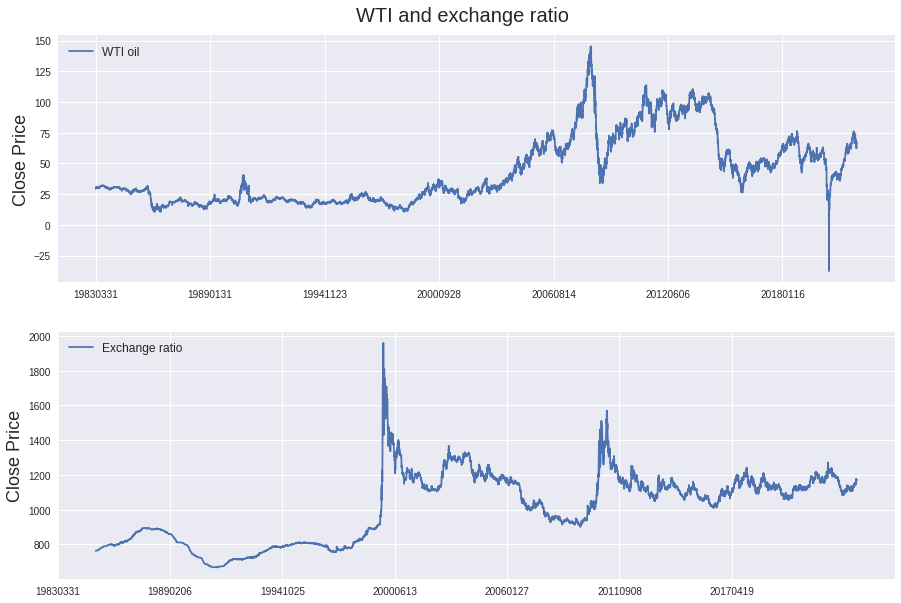

In [14]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("WTI and exchange ratio", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df_oil['Close'], label='WTI oil')
ax1.set_xticks(range(0, df_oil.shape[0], 1464))
ax1.set_xticklabels(df_oil['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df_ex['Close'], label='Exchange ratio')
ax2.set_xticks(range(0, df_ex.shape[0], 1464))
ax2.set_xticklabels(df_ex['Date'].loc[::1464])
ax2.set_ylabel('Close Price', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

## Calculate normalized percentage change of all columns


In [15]:
'''Calculate percentage change'''

df_train['Open'] = df_train['Open'].pct_change() # Create arithmetic returns column
df_train['High'] = df_train['High'].pct_change() # Create arithmetic returns column
df_train['Low'] = df_train['Low'].pct_change() # Create arithmetic returns column
df_train['Close'] = df_train['Close'].pct_change() # Create arithmetic returns column
df_train['Volume'] = df_train['Volume'].pct_change()   
df_train['Close_x'] = df_train['Close_x'].pct_change()  
df_train['Close_y'] = df_train['Close_y'].pct_change()  

df_train.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
###################################################################################### 

'''Create indexes to split dataset'''

times = sorted(df_train.index.values)
last_10pct = sorted(df_train.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df_train.index.values)[-int(0.2*len(times))] # Last 20% of series

############################################################################### 
'''Normalize all columns''' 

df_train = (df_train - df_train.mean()) / df_train.std()
df_train.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_oil', 'Close_exchange']
  ###############################################################################
'''Create training, validation and test split'''

df_train_ = df_train[(df_train.index < last_20pct)]  # Training data are 80% of total data
df_val = df_train[(df_train.index >= last_20pct) & (df_train.index < last_10pct)]
df_test = df_train[(df_train.index >= last_10pct)]
df_train = df_train_
# Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train

Training data shape: (7330, 7)
Validation data shape: (916, 7)
Test data shape: (916, 7)


,Open,High,Low,Close,Volume,Close_oil,Close_exchange
3,0.354663,0.342305,0.211169,0.198572,-0.337729,0.134145,-0.009984
4,-0.143682,-0.159947,-0.162314,-0.315568,-0.287573,0.361578,-0.009984
5,-0.435582,-0.327216,-0.264654,-0.027224,0.042147,0.208792,-0.009984
6,0.120175,0.343025,-0.027092,0.263652,2.588071,0.160847,-0.009984
8,0.295861,0.205949,0.519643,-0.027224,-0.450552,-0.099545,0.279125
...,...,...,...,...,...,...,...
8365,0.461342,-0.076683,0.230228,-0.218741,-0.137731,0.172497,-1.041536
8366,-0.115296,0.221431,0.073319,0.502511,0.212649,-0.043316,0.485732
8367,0.676464,0.711371,0.176664,-0.453822,0.128427,0.042576,-0.440733
8368,-0.758490,-0.798313,-0.278557,-0.363351,-0.312964,0.525758,0.471274


In [16]:
df_train

,Open,High,Low,Close,Volume,Close_oil,Close_exchange
3,0.354663,0.342305,0.211169,0.198572,-0.337729,0.134145,-0.009984
4,-0.143682,-0.159947,-0.162314,-0.315568,-0.287573,0.361578,-0.009984
5,-0.435582,-0.327216,-0.264654,-0.027224,0.042147,0.208792,-0.009984
6,0.120175,0.343025,-0.027092,0.263652,2.588071,0.160847,-0.009984
8,0.295861,0.205949,0.519643,-0.027224,-0.450552,-0.099545,0.279125
...,...,...,...,...,...,...,...
8365,0.461342,-0.076683,0.230228,-0.218741,-0.137731,0.172497,-1.041536
8366,-0.115296,0.221431,0.073319,0.502511,0.212649,-0.043316,0.485732
8367,0.676464,0.711371,0.176664,-0.453822,0.128427,0.042576,-0.440733
8368,-0.758490,-0.798313,-0.278557,-0.363351,-0.312964,0.525758,0.471274


In [17]:
df_val

,Open,High,Low,Close,Volume,Close_oil,Close_exchange
8370,0.237244,1.529802,0.803153,1.875166,0.280818,-0.421916,-0.029300
8371,1.642967,1.797631,1.647232,1.540793,0.140177,0.024710,-0.879290
8372,1.136893,0.338446,1.328055,0.016899,-0.324595,0.232266,0.067777
8373,0.133006,0.334613,0.112831,0.281229,-0.081975,-0.330143,0.268504
8374,0.132155,-0.116536,0.017761,0.016434,-0.269001,-0.250135,-0.232327
...,...,...,...,...,...,...,...
9284,-0.392879,-0.080322,-0.136065,0.025218,-0.201396,0.484703,-0.651063
9285,-0.027550,0.236446,0.463989,0.383717,-0.091663,0.143337,-0.272948
9286,0.295142,0.075620,-0.081818,-0.129092,-0.144570,0.225786,0.197479
9287,-0.301617,-0.492530,-0.565250,-0.689052,-0.161626,-0.330527,0.761435


In [18]:
df_test

,Open,High,Low,Close,Volume,Close_oil,Close_exchange
9289,-0.214623,-0.292162,-0.578036,-0.342493,-0.035500,-0.276066,-0.245458
9290,-0.075705,-0.241444,0.308104,0.025010,-0.196745,0.040022,0.758844
9291,-0.264324,-0.509956,-0.913555,-0.661189,-0.130198,0.387055,-0.600845
9292,-0.792111,-0.518497,0.029103,0.296774,-0.265415,-0.353713,0.350386
9293,0.365437,1.355892,0.426997,1.039018,0.244719,0.060058,0.157666
...,...,...,...,...,...,...,...
10204,-1.237025,-0.660337,-0.269503,0.549911,-0.332219,-0.393545,-0.861960
10205,0.182457,-0.378945,-0.149148,-0.934828,-0.037880,-0.626836,0.727007
10206,-0.548936,-0.560330,-1.374436,-0.960394,0.066188,-0.498746,-0.142525
10207,-0.876454,0.394225,0.291462,1.293076,-0.220319,1.233785,-0.689759


## Plot daily changes of close prices and volume

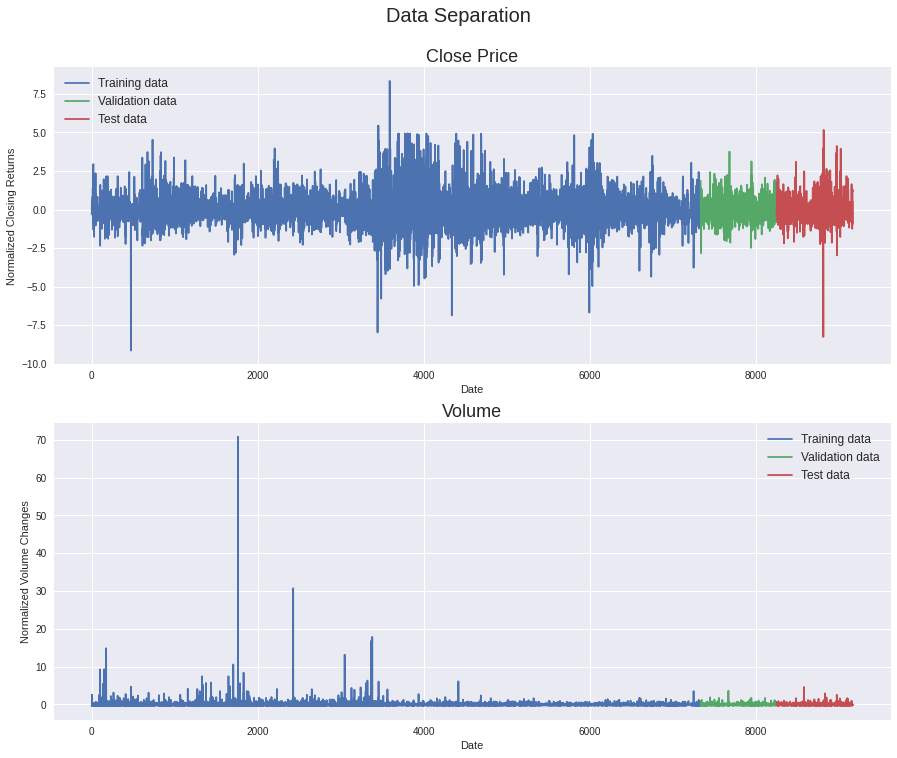

In [19]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

## Create chunks of training , validation and test data


In [20]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (7202, 128, 7) (7202,)
Validation set shape (788, 128, 7) (788,)
Testing set shape (788, 128, 7) (788,)


## Time Vector 


In [25]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x_1 = tf.math.reduce_mean(x[:,:,:4], axis=-1)  
    x_2 = tf.math.reduce_mean(x[:,:,5:], axis=-1)  
    x = (4*x_1 + 2*x_2)/6
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

## Transformer 


In [26]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 9), input_shape[0][-1]=9 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 9), input_shape[0][-1] = 9
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

## Model 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 7)]     0                                            
__________________________________________________________________________________________________
time2_vector_1 (Time2Vector)    (None, 128, 2)       512         input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 128, 9)       0           input_2[0][0]                    
                                                                 time2_vector_1[0][0]             
__________________________________________________________________________________________________
transformer_encoder_3 (Transfor (None, 128, 9)       124726      concatenate_1[0][0]        

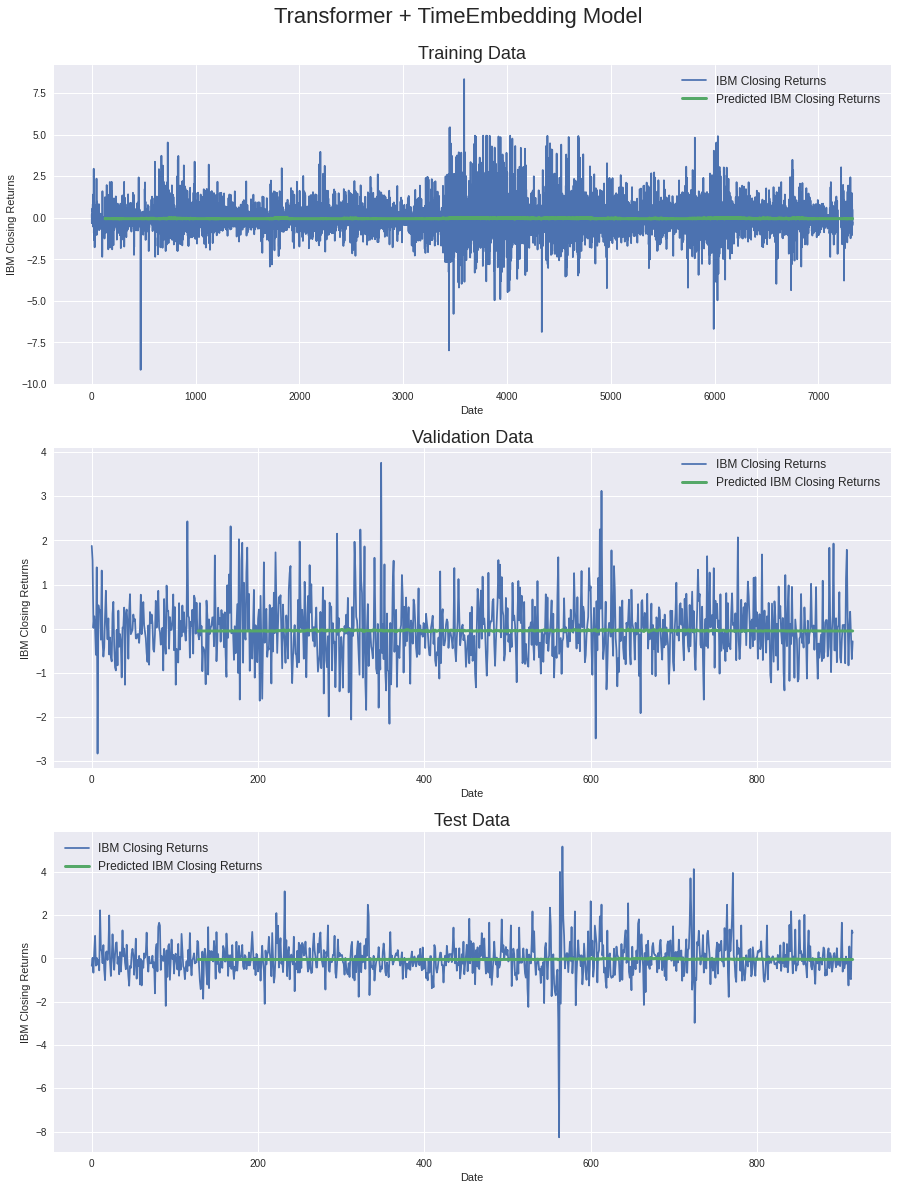

In [27]:
def create_model():
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, 7))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])
  return model


model = create_model()
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=35, 
                    callbacks=[callback],
                    validation_data=(X_val, y_val))  

model = tf.keras.models.load_model('/content/Transformer+TimeEmbedding.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})


###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
ax31.legend(loc="best", fontsize=12)